In [1]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
from aa_train_utils.dataset_generation import joint, uniform, f2, RegressionDataset , generate_noisy_split_trainingdata
from aa_train_utils.spl_curriculum import SPL_curriculum 

import jax
import jax.numpy as jnp
import jax.tree_util
import pickle
from torch.utils.data import Dataset
from torch.utils.data import Subset

import numpy as np
import pickle
import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data



2024-05-22 22:14:46.294884: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(1, 2), but only accepts 2 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted func

In [2]:
""" TODO:

    - Add validation set to the training loop and log it (In distribution , out of task distribution validations?)

    - Determine how to make sure that SPL curricula and Baseline trains on the same amount of data, as currently SPL doesnt train for same steps with the same epoch number (Maybe introduce a trainined_step_number to cut the training?)

    - Create the empirical cross entropy difficulty measure and use it for the validation set as well. 

    - SPL curriculum call with best_params or just params for the loss calculation based ordering?

    - Additionally maybe increase the difficulty of the dataset a bit , for smoother learning curve, more interesting results? 
        - Could also look into creating a more diverse dataset , the split dataset generator would allow for that easily. 


"""

def train_spl_curriculum(dataset_key_int, dataset_size, training_step_number, sampler_ratios, chunk_size, save_path ,  model_name, start_rate, growth_epochs):
    
    """ Training function for the SPL curriculum based Neural Process model training"""



    # Lets define the training functions here and not in their own files, because I couldnt make them modular enough.
    # (The posterior loss was relying on the global variable model, I tried creating a partial with the params not included to have the scan carry over a new param based partial to the step function but it wasnt working, this works for now)

    def posterior_loss(
        params: flax.typing.VariableDict,
        batch,
        key: flax.typing.PRNGKey,
    ):
        key_data, key_model = jax.random.split(key)
        


        X = batch[0]
        y = batch[1]
        x_test = batch[2]
        y_test = batch[3]
        # Compute ELBO over batch of datasets
        elbos = jax.vmap(
        partial(
                model.apply,
                params,  
                beta=kl_penalty,
                k=num_posterior_mc,
                method=model.elbo
        ) 
        )(
            X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
        )
        
        return -elbos.mean()

    @jax.jit
    def step(
        theta: flax.typing.VariableDict, 
        opt_state: optax.OptState,
        current_batch,
        random_key: flax.typing.PRNGKey,
    ) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
        # Implements a generic SGD Step
        
        # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
        value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )
        
        updates, opt_state = optimizer.update(grad, opt_state, theta)
        theta = optax.apply_updates(theta, updates)
        
        return theta, opt_state, value


    def body_batch(carry, batch):
        params, opt_state, key = carry
        key_carry, key_step = jax.random.split(key)

        X, x_test = jnp.split(batch[0], indices_or_sections=(num_context_samples, ), axis=1)
        y, y_test = jnp.split(batch[1], indices_or_sections=(num_context_samples, ), axis=1)
        params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

        return (params, opt_state, key_carry ), value

    jax.jit
    def scan_train(params, opt_state, key,  batches):
        
        last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

        params, opt_state, _ = last
        
        return params, opt_state, out


    os.makedirs(save_path, exist_ok=True)
    num_context_samples = 64
    num_target_samples = 32
    batch_size = 128
    kl_penalty = 1e-4
    num_posterior_mc = 1


    # First lets create the dataset, 
    # Lets hardcode it for now, and then we can make it more flexible later on
    
    sampler_noise = partial(
        joint, 
        WhiteNoise(f2, 0.1), 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    sampler_clean = partial(
        joint, 
        f2, 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    samplers = [sampler_noise, sampler_clean]

    dataset_key = jax.random.PRNGKey(dataset_key_int)
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size , dataset_key))

    # Lets setup the SPL curriculum

    rng , curricula_key = jax.random.split(dataset_key)
    spl_curricula = SPL_curriculum(start_rate, growth_epochs , dataset, batch_size, curricula_key)



    # Lets initalize the model we are going to train

    rng, key = jax.random.split(rng)

    model , params = create_model(key)
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)

    best, best_params = jnp.inf, params
    losses = list()

    for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):
        
        rng, key = jax.random.split(rng)
        model_partial_loss_function = partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo) 
        batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in spl_curricula.data_curriculum(model_partial_loss_function, i, num_context_samples)]))
        # params_new, opt_state, loss = step(params, opt_state, key)
        params_new, opt_state, loss_arr = scan_train(params, opt_state, key,batches)

        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params_new
        
        if jnp.isnan(loss_arr).any():
            break
        else:
            params = params_new
        
        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

    # Lets save what we need to save for the model and training. 

    ### After training we should save  
        # the model parameters with a name that we know how it was trained
        # the losses and other relevant information accrued during training
        # the curriculum weight log for the dataset

    # Saving the model params
    # We could also save opt_state here for later training
    # Also after trying out whether the training would continue saving and loading the params back in I saw change in printed loss. Not sure why that is the case,
    # Even if I restore the opt_state as well. Regardless, the model continued training so saving the params is enough to use the model for evaluation later on. 
    
    save_model_params(best_params,save_path, model_name) 
    
    with open(os.path.join(save_path, model_name + '_curricula_weights.pkl'), 'wb') as f:
        if(len(spl_curricula.weight_log)>0):
            pickle.dump(spl_curricula.weight_log, f)
    
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump(losses, f)



In [3]:

train_spl_curriculum(0, 128*10, 10, [0.3,0.7], 128, "./spl_training_data/", "spl_model_0", 0.1, 5)

Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.3075:  10%|█         | 1/10 [00:07<01:05,  7.23s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8160:  20%|██        | 2/10 [00:13<00:51,  6.40s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5721:  30%|███       | 3/10 [00:19<00:44,  6.30s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.3900:  40%|████      | 4/10 [00:25<00:37,  6.31s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2755:  50%|█████     | 5/10 [00:31<00:31,  6.20s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.0826:  60%|██████    | 6/10 [00:37<00:24,  6.21s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0186:  70%|███████   | 7/10 [00:44<00:18,  6.22s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9542:  80%|████████  | 8/10 [00:46<00:10,  5.04s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9240:  90%|█████████ | 9/10 [00:49<00:04,  4.26s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. Loss: 0.8239: 100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


In [4]:
# Lets try training it severeal times in a for loop to see if we get oom errors or not. 
for i in range(10):
    train_spl_curriculum(i, 128*10, 10, [0.3,0.7], 128, "./spl_training_data"+str(i)+"/", "spl_model_"+str(i), 0.1, 5)

Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.2432:  10%|█         | 1/10 [00:05<00:46,  5.22s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8336:  20%|██        | 2/10 [00:10<00:41,  5.14s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5257:  30%|███       | 3/10 [00:15<00:37,  5.30s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4169:  40%|████      | 4/10 [00:21<00:33,  5.58s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2618:  50%|█████     | 5/10 [00:28<00:29,  5.83s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1160:  60%|██████    | 6/10 [00:34<00:24,  6.02s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0250:  70%|███████   | 7/10 [00:40<00:18,  6.18s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 1.0068:  80%|████████  | 8/10 [00:43<00:10,  5.11s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.8860:  90%|█████████ | 9/10 [00:46<00:04,  4.34s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 12.6976:  10%|█         | 1/10 [00:05<00:48,  5.42s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8198:  20%|██        | 2/10 [00:10<00:43,  5.46s/it] 

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5832:  30%|███       | 3/10 [00:16<00:39,  5.61s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.5028:  40%|████      | 4/10 [00:22<00:34,  5.68s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3039:  50%|█████     | 5/10 [00:28<00:29,  5.82s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1528:  60%|██████    | 6/10 [00:34<00:23,  5.93s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0303:  70%|███████   | 7/10 [00:40<00:18,  6.03s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 1.0281:  80%|████████  | 8/10 [00:43<00:10,  5.05s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.8799:  90%|█████████ | 9/10 [00:46<00:04,  4.31s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.0293:  10%|█         | 1/10 [00:05<00:48,  5.39s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8983:  20%|██        | 2/10 [00:10<00:44,  5.51s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5126:  30%|███       | 3/10 [00:16<00:39,  5.65s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4360:  40%|████      | 4/10 [00:22<00:34,  5.72s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2979:  50%|█████     | 5/10 [00:28<00:29,  5.84s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1679:  60%|██████    | 6/10 [00:34<00:23,  5.96s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.1244:  70%|███████   | 7/10 [00:41<00:18,  6.08s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 1.0052:  80%|████████  | 8/10 [00:44<00:10,  5.04s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9481:  90%|█████████ | 9/10 [00:46<00:04,  4.35s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 1.8860:  10%|█         | 1/10 [00:05<00:50,  5.57s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 2.0458:  20%|██        | 2/10 [00:11<00:44,  5.54s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.6623:  30%|███       | 3/10 [00:16<00:39,  5.57s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4915:  40%|████      | 4/10 [00:22<00:34,  5.68s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3321:  50%|█████     | 5/10 [00:29<00:29,  5.99s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1743:  60%|██████    | 6/10 [00:35<00:24,  6.11s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0359:  70%|███████   | 7/10 [00:41<00:18,  6.23s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9805:  80%|████████  | 8/10 [00:44<00:10,  5.13s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9469:  90%|█████████ | 9/10 [00:47<00:04,  4.38s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 1.9831:  10%|█         | 1/10 [00:05<00:49,  5.53s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.6946:  20%|██        | 2/10 [00:11<00:43,  5.50s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.6743:  30%|███       | 3/10 [00:16<00:39,  5.70s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4648:  40%|████      | 4/10 [00:23<00:35,  5.86s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3346:  50%|█████     | 5/10 [00:29<00:30,  6.01s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1560:  60%|██████    | 6/10 [00:35<00:24,  6.19s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0930:  70%|███████   | 7/10 [00:42<00:19,  6.41s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 1.0114:  80%|████████  | 8/10 [00:45<00:10,  5.28s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9747:  90%|█████████ | 9/10 [00:48<00:04,  4.50s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.2153:  10%|█         | 1/10 [00:05<00:49,  5.45s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.7433:  20%|██        | 2/10 [00:10<00:42,  5.37s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5782:  30%|███       | 3/10 [00:16<00:40,  5.73s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4534:  40%|████      | 4/10 [00:22<00:34,  5.78s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3176:  50%|█████     | 5/10 [00:29<00:29,  5.95s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.0952:  60%|██████    | 6/10 [00:35<00:24,  6.20s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0471:  70%|███████   | 7/10 [00:42<00:19,  6.35s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9730:  80%|████████  | 8/10 [00:45<00:10,  5.27s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9374:  90%|█████████ | 9/10 [00:48<00:04,  4.49s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 1.9254:  10%|█         | 1/10 [00:05<00:50,  5.61s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.9344:  20%|██        | 2/10 [00:11<00:45,  5.63s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5819:  30%|███       | 3/10 [00:17<00:40,  5.77s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4562:  40%|████      | 4/10 [00:23<00:36,  6.04s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3013:  50%|█████     | 5/10 [00:30<00:30,  6.18s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1480:  60%|██████    | 6/10 [00:36<00:25,  6.25s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0415:  70%|███████   | 7/10 [00:43<00:19,  6.35s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9256:  80%|████████  | 8/10 [00:45<00:10,  5.23s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9124:  90%|█████████ | 9/10 [00:48<00:04,  4.48s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 5.5473:  10%|█         | 1/10 [00:05<00:47,  5.31s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8736:  20%|██        | 2/10 [00:10<00:42,  5.34s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5861:  30%|███       | 3/10 [00:16<00:38,  5.51s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4594:  40%|████      | 4/10 [00:22<00:33,  5.66s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.3184:  50%|█████     | 5/10 [00:28<00:29,  5.87s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1484:  60%|██████    | 6/10 [00:35<00:24,  6.12s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0401:  70%|███████   | 7/10 [00:41<00:18,  6.24s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9605:  80%|████████  | 8/10 [00:44<00:10,  5.11s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 1.0042:  90%|█████████ | 9/10 [00:47<00:04,  4.39s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.5502:  10%|█         | 1/10 [00:05<00:48,  5.43s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.7971:  20%|██        | 2/10 [00:10<00:43,  5.39s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5380:  30%|███       | 3/10 [00:16<00:38,  5.51s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4008:  40%|████      | 4/10 [00:22<00:34,  5.72s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2875:  50%|█████     | 5/10 [00:28<00:29,  5.90s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1088:  60%|██████    | 6/10 [00:35<00:24,  6.04s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 0.9831:  70%|███████   | 7/10 [00:41<00:18,  6.14s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9083:  80%|████████  | 8/10 [00:44<00:10,  5.06s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9079:  90%|█████████ | 9/10 [00:46<00:04,  4.31s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 1.8737:  10%|█         | 1/10 [00:05<00:52,  5.83s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.7556:  20%|██        | 2/10 [00:11<00:44,  5.59s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.6156:  30%|███       | 3/10 [00:16<00:39,  5.61s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4573:  40%|████      | 4/10 [00:22<00:34,  5.73s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2843:  50%|█████     | 5/10 [00:28<00:29,  5.87s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1459:  60%|██████    | 6/10 [00:35<00:24,  6.00s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0511:  70%|███████   | 7/10 [00:41<00:18,  6.13s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 0.9536:  80%|████████  | 8/10 [00:44<00:10,  5.09s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.8773:  90%|█████████ | 9/10 [00:47<00:04,  4.34s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. Loss: 0.9135: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


[(128,), (358,), (588,), (819,), (1049,), (1279,), (1280,), (1280,), (1280,), (1280,)]
------
{'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bi

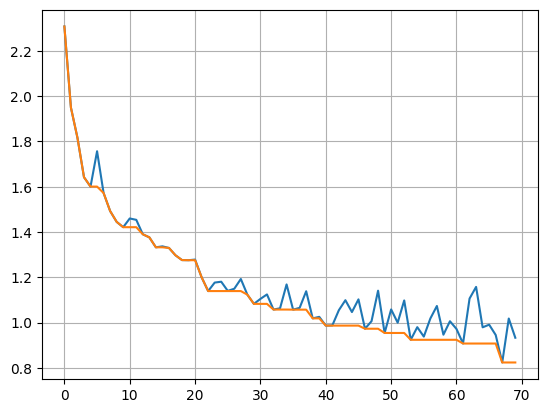

In [5]:
# Lets check if the necessary savings happened nicely

# First the curriculum weights. 

with open("./spl_training_data/spl_model_0_curricula_weights.pkl", 'rb') as f:
    weight_log = pickle.load(f)

print([w.shape for w in weight_log])
print("------")

# Now the training metrics

with open("./spl_training_data/spl_model_0_training_metrics.pkl", 'rb') as f:
    losses = pickle.load(f)

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

# Finally the model params

params = load_model_params("./spl_training_data/spl_model_0.pkl")

print(jax.tree_util.tree_map(lambda x: x.shape, params))